In [0]:
# library import
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets

import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

In [0]:
# define hyperparameters
batch_size = 100
num_epoches = 300

learning_rate = 1e-3
betas=(0.9, 0.999)
weight_decay=1e-3


use_gpu = torch.cuda.is_available()  # determine whether it has gpu speed up

In [18]:
# load data into environment
X_test = np.load("data/X_test.npy")
y_test = np.load("data/y_test.npy")
person_train_valid = np.load("data/person_train_valid.npy")
X_train_valid = np.load("data/X_train_valid.npy")
y_train_valid = np.load("data/y_train_valid.npy")
person_test = np.load("data/person_test.npy")

print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))


Training/Valid data shape: (2115, 25, 1000)
Test data shape: (443, 25, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [0]:
# clean eeg data
X_train = X_train_valid[:, :22, :]
X_test = X_test[:, :22, :]

X_train = X_train.reshape((2115, 1, 22, 1000))
X_test = X_test.reshape((443, 1, 22, 1000))


trainset = torch.utils.data.TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train_valid - 769).long())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torch.utils.data.TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test - 769).long())
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)


In [0]:
def plot_acc(recover_acc):
    plt.plot(recover_acc, label = "recover_acc")
    plt.xlabel("eopch")
    plt.ylabel("accuracy")
    plt.legend()
    plt.title("The accuracy against epoch")
    plt.show()

In [0]:
class EncoderRNN(nn.Module):
    def __init__(self):
        super(EncoderRNN, self).__init__()
        self.encode = nn.Sequential(
            nn.Conv2d(1, 16, (4, 120), stride=(3, 10), padding=(3, 5)),  # b, 16, 9, 90
            nn.ReLU(True),
            nn.MaxPool2d((3, 10), stride=2),  # b, 16, 4, 40
            nn.Conv2d(16, 8, (2, 4), stride=2, padding=1),  # b, 8, 3, 20
            nn.ReLU(True),
        )
        self.decode = nn.Sequential(
            nn.ConvTranspose2d(8, 16, (3, 4), stride=(2,4)),  # b, 16, 7, 80
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, (5, 15), stride=(2, 3), padding=(3, 1)),  # b, 8, 11, 240
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, (4, 6), stride=(2, 4), padding=1),  # b, 1, 22, 1000
            nn.Tanh()          
        )
                        

    def forward(self, x):
        out = self.encode(x)
        out = self.decode(out)
        return out
encoder = EncoderRNN()
if use_gpu:
    encoder = encoder.cuda()


In [0]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(encoder.parameters(), lr=learning_rate)

epoch [1/300], loss:122.4551
epoch [2/300], loss:111.7008
epoch [3/300], loss:112.0401
epoch [4/300], loss:125.2557
epoch [5/300], loss:126.2148
epoch [6/300], loss:122.2529
epoch [7/300], loss:135.8323
epoch [8/300], loss:127.9550
epoch [9/300], loss:116.6915
epoch [10/300], loss:92.5818
epoch [11/300], loss:89.8713
epoch [12/300], loss:102.7172
epoch [13/300], loss:105.5818
epoch [14/300], loss:117.8196
epoch [15/300], loss:106.9211
epoch [16/300], loss:101.6604
epoch [17/300], loss:117.0328
epoch [18/300], loss:137.2297
epoch [19/300], loss:113.5809
epoch [20/300], loss:112.7447
epoch [21/300], loss:127.8718
epoch [22/300], loss:124.6803
epoch [23/300], loss:127.0124
epoch [24/300], loss:102.3352
epoch [25/300], loss:112.0619
epoch [26/300], loss:110.1403
epoch [27/300], loss:119.7218
epoch [28/300], loss:121.5284
epoch [29/300], loss:109.7395
epoch [30/300], loss:101.8750
epoch [31/300], loss:101.8460
epoch [32/300], loss:107.9217
epoch [33/300], loss:103.5307
epoch [34/300], loss:

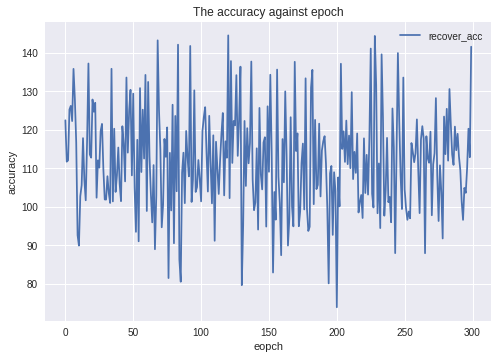

In [23]:
recover_acc = []

for epoch in range(num_epoches):
    for batch_idx, (signals, tags) in enumerate(trainloader):
        encoder.zero_grad()
        if use_gpu:
            signals = Variable(signals).cuda()
            tags = Variable(tags).cuda()
        else:
            signals = Variable(signals)
            tags = Variable(tags)
        # ===================forward=====================
        output = encoder(signals)
        loss = criterion(output, signals)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch+1, num_epoches, loss.data.item()))
    recover_acc.append(loss.data.item())
plot_acc(recover_acc)   